# Audio compression with EnCodec and OpenVINO

Compression is an important part of the Internet today because it enables people to easily share high-quality photos, listen to audio messages, stream their favorite shows, and so much more. Even when using today’s state-of-the-art techniques, enjoying these rich multimedia experiences requires a high speed Internet connection and plenty of storage space. AI helps to overcome these limitations: "Imagine listening to a friend’s audio message in an area with low connectivity and not having it stall or glitch."

This tutorial considers ways to use OpenVINO and EnCodec algorithm for hyper compression of audio.
EnCodec is a real-time, high-fidelity audio codec that uses AI to compress audio files without losing quality. It was introduced in [High Fidelity Neural Audio Compression](https://arxiv.org/pdf/2210.13438.pdf) paper by Meta AI. The researchers claimed they achieved an approximate 10x compression rate without loss of quality and made it work for CD-quality audio. More details about this approach can be found in [Meta AI blog](https://ai.facebook.com/blog/ai-powered-audio-compression-technique/) and original [repo](https://github.com/facebookresearch/encodec).

![image.png](https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/17546d66-12b9-4841-9293-cc878258a186)

#### Table of contents:
- [Prerequisites](#Prerequisites)
- [Instantiate audio compression pipeline](#Instantiate-audio-compression-pipeline)
- [Explore EnCodec pipeline](#Explore-EnCodec-pipeline)
    - [Preprocessing](#Preprocessing)
    - [Encoding](#Encoding)
    - [Decompression](#Decompression)
- [Convert model to OpenVINO Intermediate Representation format](#Convert-model-to-OpenVINO-Intermediate-Representation-format)
- [Integrate OpenVINO to EnCodec pipeline](#Integrate-OpenVINO-to-EnCodec-pipeline)
    - [Select inference device](#Select-inference-device)
- [Run EnCodec with OpenVINO](#Run-EnCodec-with-OpenVINO)


## Prerequisites
[back to top ⬆️](#Table-of-contents:)

Install required dependencies:

In [1]:
%pip install -q --extra-index-url https://download.pytorch.org/whl/cpu "openvino>=2023.3.0" "torch>=2.1" "torchaudio>=2.1" encodec gradio "librosa>=0.8.1"

## Instantiate audio compression pipeline
[back to top ⬆️](#Table-of-contents:)

[Codecs](https://en.wikipedia.org/wiki/Codec), which act as encoders and decoders for streams of data, help empower most of the audio compression people currently use online. Some examples of commonly used codecs include MP3, Opus, and EVS. Classic codecs like these decompose the signal between different frequencies and encode as efficiently as possible. Most classic codecs leverage human hearing knowledge (psychoacoustics) but have a finite or given set of handcrafted ways to efficiently encode and decode the file. EnCodec, a neural network that is trained from end to end to reconstruct the input signal, was introduced as an attempt to overcome this limitation. It consists of three parts:

* The **encoder**, which takes the uncompressed data in and transforms it into a higher dimensional and lower frame rate representation.

* The **quantizer**, which compresses this representation to the target size. This compressed representation is what is stored on disk or will be sent through the network.

* The **decoder** is the final step. It turns the compressed signal back into a waveform that is as similar as possible to the original. The key to lossless compression is to identify changes that will not be perceivable by humans, as perfect reconstruction is impossible at low bit rates.

![encodec_compression](https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/5cd9a482-b42b-4dea-85a5-6d66b20ce13d))


The authors provide two multi-bandwidth models:
* `encodec_model_24khz` - a causal model operating at 24 kHz on monophonic audio trained on a variety of audio data.
* `encodec_model_48khz` - a non-causal model operating at 48 kHz on stereophonic audio trained on music-only data.

In this tutorial, we will use `encodec_model_24khz` as an example, but the same actions are also applicable to `encodec_model_48khz` model as well.
To start working with this model, we need to instantiate model class using `EncodecModel.encodec_model_24khz()` and select required compression bandwidth among available: 1.5, 3, 6, 12 or 24 kbps for 24 kHz model and 3, 6, 12 and 24 kbps for 48 kHz model. We will use 6 kbps bandwidth.

In [2]:
from encodec import compress, decompress
from encodec.utils import convert_audio, save_audio
from encodec.compress import MODELS
import torchaudio
import torch
import typing as tp

model_id = "encodec_24khz"
# Instantiate a pretrained EnCodec model
model = MODELS[model_id]()
model.set_target_bandwidth(6.0)

/home/ea/work/genai_env/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


## Explore EnCodec pipeline
[back to top ⬆️](#Table-of-contents:)

Let us explore model capabilities on example audio:

'test_24k.wav' already exists.


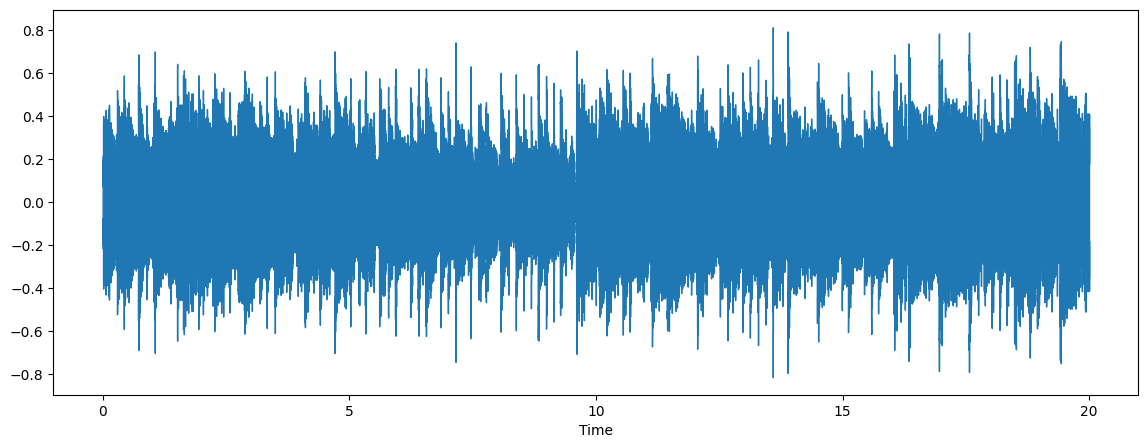

In [3]:
import sys
import librosa
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd

sys.path.append("../utils")

from notebook_utils import download_file

test_data_url = "https://github.com/facebookresearch/encodec/raw/main/test_24k.wav"

sample_file = 'test_24k.wav'
download_file(test_data_url, sample_file)
audio, sr = librosa.load(sample_file)
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio, sr=sr)

ipd.Audio(sample_file)

### Preprocessing
[back to top ⬆️](#Table-of-contents:)

To achieve the best result, audio should have the number of channels and sample rate expected by the model. If audio does not fulfill these requirements, it can be converted to the desired sample rate and the number of channels using the `convert_audio` function.

In [4]:
model_sr, model_channels = model.sample_rate, model.channels
print(f"Model expected sample rate {model_sr}")
print(f"Model expected audio format {'mono' if model_channels == 1 else 'stereo'}")

Model expected sample rate 24000
Model expected audio format mono


In [5]:
# Load and pre-process the audio waveform
wav, sr = torchaudio.load(sample_file)

wav = convert_audio(wav, sr, model_sr, model_channels)

### Encoding
[back to top ⬆️](#Table-of-contents:)

Audio waveform should be split by chunks and then encoded by Encoder model, then compressed by quantizer for reducing memory. The result of compression is a binary file with `ecdc` extension, a special format for storing EnCodec compressed audio on disc.

In [6]:
from pathlib import Path


out_file = Path("compressed.ecdc")
b = compress(model, wav)
out_file.write_bytes(b)

15067

Let us compare obtained compression result:

In [7]:
import os

orig_file_stats = os.stat(sample_file)
compressed_file_stats = os.stat("compressed.ecdc")
print(f"size before compression in Bytes: {orig_file_stats.st_size}")
print(f"size after compression in Bytes: {compressed_file_stats.st_size}")
print(f"Compression file size ratio: {orig_file_stats.st_size / compressed_file_stats.st_size:.2f}")

size before compression in Bytes: 960078
size after compression in Bytes: 15067
Compression file size ratio: 63.72


Great! Now, we see the power of hyper compression. Binary size of a file becomes 60 times smaller and more suitable for sending via network.

### Decompression
[back to top ⬆️](#Table-of-contents:)

After successful sending of the compressed audio, it should be decompressed on the recipient's side. The decoder model is responsible for restoring the compressed signal back into a waveform that is as similar as possible to the original.

In [8]:
out, out_sr = decompress(out_file.read_bytes())

/home/ea/work/genai_env/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [9]:
output_file = "decopressed.wav"
save_audio(out, output_file, out_sr)

The decompressed audio will be saved to the `decompressed.wav` file when decompression is finished. We can compare result with the original audio.

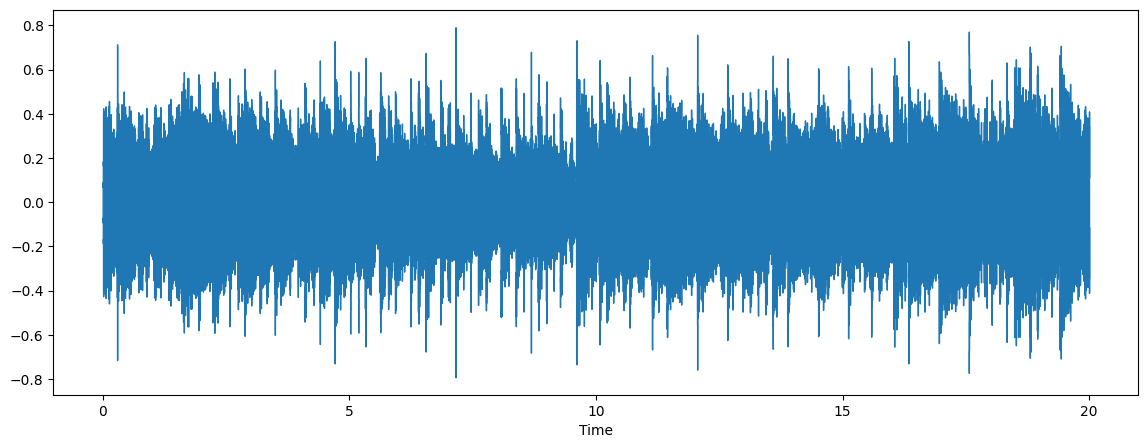

In [10]:
audio, sr = librosa.load(output_file)
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio, sr=sr)

ipd.Audio(output_file)

Nice! Audio sounds close to original.

## Convert model to OpenVINO Intermediate Representation format
[back to top ⬆️](#Table-of-contents:)

For best results with OpenVINO, it is recommended to convert the model to OpenVINO IR format. OpenVINO supports PyTorch via conversion to OpenVINO IR format. We need to provide initialized model's instance and example of inputs for shape inference. We will use `ov.convert_model` functionality to convert the PyTorch models. The `ov.convert_model` Python function returns an OpenVINO model ready to load on the device and start making predictions. We can save it on disk for the next usage with `ov.save_model`.

In [11]:
class FrameEncoder(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x: torch.Tensor):
        codes, scale = self.model._encode_frame(x)
        if not self.model.normalize:
            return codes
        return codes, scale        

In [12]:
class FrameDecoder(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, codes, scale=None):
        return model._decode_frame((codes, scale))

In [13]:
encoder = FrameEncoder(model)
decoder = FrameDecoder(model)

In [14]:
import openvino as ov


core = ov.Core()

OV_ENCODER_PATH = Path("encodec_encoder.xml")
if not OV_ENCODER_PATH.exists():
    encoder_ov = ov.convert_model(encoder, example_input=torch.zeros(1, 1, 480000), input=[[1, 1, 480000]])
    ov.save_model(encoder_ov, OV_ENCODER_PATH)
else:
    encoder_ov = core.read_model(OV_ENCODER_PATH)

In [15]:
OV_DECODER_PATH = Path("encodec_decoder.xml")
if not OV_DECODER_PATH.exists():
    decoder_ov = ov.convert_model(decoder, example_input=torch.zeros([1, 8, 1500], dtype=torch.long), input=[[1, 8, 1500]])
    ov.save_model(decoder_ov, OV_DECODER_PATH)
else:
    decoder_ov = core.read_model(OV_DECODER_PATH)

## Integrate OpenVINO to EnCodec pipeline
[back to top ⬆️](#Table-of-contents:)

The following steps are required for integration of OpenVINO to EnCodec pipeline:

1. Load the model to a device.
2. Define audio frame processing functions.
3. Replace the original frame processing functions with OpenVINO based algorithms.

### Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [16]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

In [17]:
compiled_encoder = core.compile_model(encoder_ov, device.value)
encoder_out = compiled_encoder.output(0)

compiled_decoder = core.compile_model(decoder_ov, device.value)
decoder_out = compiled_decoder.output(0)

In [18]:
def encode_frame(x: torch.Tensor):
    has_scale = len(compiled_encoder.outputs) == 2
    result = compiled_encoder(x)
    codes = torch.from_numpy(result[encoder_out])
    if has_scale:
        scale = torch.from_numpy(result[compiled_encoder.output(1)])
    else:
        scale = None
    return codes, scale

In [19]:
EncodedFrame = tp.Tuple[torch.Tensor, tp.Optional[torch.Tensor]]


def decode_frame(encoded_frame: EncodedFrame):
    codes, scale = encoded_frame
    inputs = [codes]
    if scale is not None:
        inputs.append(scale)
    return torch.from_numpy(compiled_decoder(inputs)[decoder_out])

In [20]:
model._encode_frame = encode_frame
model._decode_frame = decode_frame

MODELS[model_id] = lambda : model

## Run EnCodec with OpenVINO
[back to top ⬆️](#Table-of-contents:)

The process of running encodec with OpenVINO under hood will be the same like with the original PyTorch models.

In [21]:
b = compress(model, wav, use_lm=False)
out_file = Path("compressed_ov.ecdc")
out_file.write_bytes(b)

15067

In [22]:
out, out_sr = decompress(out_file.read_bytes())

In [23]:
ov_output_file = "decopressed_ov.wav"
save_audio(out, ov_output_file, out_sr)

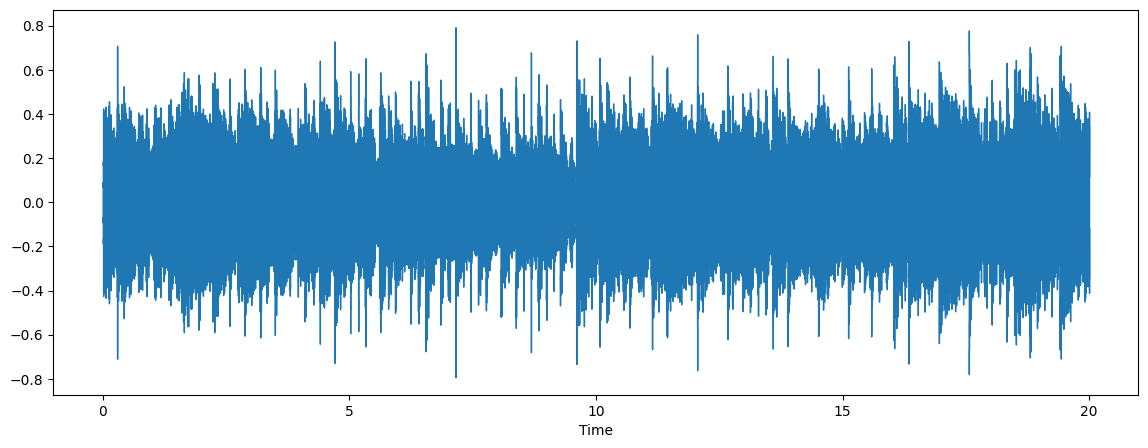

In [24]:
audio, sr = librosa.load(ov_output_file)
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio, sr=sr)

ipd.Audio(ov_output_file)

In [ ]:
import gradio as gr
from typing import Tuple
import numpy as np

def preprocess(input, sample_rate, model_sr, model_channels):
    input = torch.tensor(input, dtype=torch.float32)
    input = input / 2**15  # adjust to int16 scale
    input = input.unsqueeze(0)
    input = convert_audio(input, sample_rate, model_sr, model_channels)
    
    return input


def postprocess(output):
    output = output.squeeze()
    output = output * 2**15  # adjust to [-1, 1] scale
    output = output.numpy(force=True)
    output = output.astype(np.int16)

    return output
    

def _compress(input: Tuple[int, np.ndarray]):
    sample_rate, waveform = input
    waveform = preprocess(waveform, sample_rate, model_sr, model_channels)
    
    b = compress(model, waveform, use_lm=False)
    out, out_sr = decompress(b)
    
    out = postprocess(out)
    return out_sr, out
    
demo = gr.Interface(
    _compress,
    'audio',
    'audio',
    examples=['test_24k.wav']
)
    
try:
    demo.launch(debug=True)
except Exception:
    demo.launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/